In [1]:
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
def function_S(input):
    # input should be array
    # output array
    flattened_input = input.flatten()
    output = [[0,           -flattened_input[2],    flattened_input[1]],
              [flattened_input[2],  0,              -flattened_input[0]],
              [-flattened_input[1], flattened_input[0],     0]]
    return np.array(output)

In [3]:
def rodrigues_formula(quaternion):
    '''
    quaternion -> R_tilde_bar
    input: [w,x,y,z]
    output R_tile_bar (rotation matrix)
    From page6
    '''
    return np.eye(3) + 2*np.matmul(function_S(quaternion[1:]), (quaternion[0]*np.eye(3) + function_S(quaternion[1:])))


In [4]:
l = 3
k = 1
q = [10, 10, 10]
Q = np.diag(np.hstack([np.diag(q[0]*np.eye(3)), np.diag(q[1]*np.eye(3)), np.diag(q[2]*np.eye(3))]))
V = np.diag(np.hstack([np.diag(0.1*np.eye(3)), np.diag(np.eye(3))]))
P_0 = np.diag(np.hstack([np.diag(np.eye(3)), np.diag(100*np.eye(3))]))

#initial state
p_0 = np.array([[2.5, 0, 10]], dtype=np.float64).T
R_0 = np.eye(3)

#initial estimation
p_hat_0 = np.array([[-2, 4, 3]], dtype=np.float64).T
Lambda_bar_0 = np.array([np.sqrt(2)/2, np.sqrt(2)/2, 0, 0]).T  # quaternion: w, x, y, z

## R_hat = R x R_tilde_bar
R_hat_0 = np.matmul(R_0, rodrigues_formula(Lambda_bar_0))

# landmarks
z = np.array([[[0, 0, 0]], 
              [[5, 0, 0]],
              [[2.5, 2.5, 0]]])

In [5]:
def function_A(omega):
    A11 = function_S(-omega)
    A12 = np.zeros((3,3))
    A21 = np.zeros((3,3))
    A22 = function_S(-omega)
    return np.vstack((np.hstack((A11, A12)), np.hstack((A21, A22))))


In [6]:
def function_Pi(input):
    '''
    Pi_x := I_3 - xx^T
    input: array
    output P_x
    '''
    return np.eye(3) - np.matmul(input, np.transpose(input))

In [7]:
def function_d(input_rot, input_p, input_z):
    '''
    calculate d_i(t) := R^T(t)(p(t) - z_i)/|p(t)-z_i|
    '''
    norm = (input_p - input_z)/np.linalg.norm(input_p - input_z)
    return np.matmul(np.transpose(input_rot), norm)

In [8]:
def function_C(input_R, input_R_hat, input_p, input_z):
    for landmark_idx in range(l):
        # S(R_hat.T x z)
        #TODO: remember to change the R_0 and p_0 below for gerenal
        first = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx])))
        second = function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        final = -np.matmul(first, second)
        C_landmark = np.hstack((final, first))
        if landmark_idx == 0:
            output_C = C_landmark
        else:
            output_C = np.vstack((output_C, C_landmark))
    return output_C

In [9]:
def add_bar(input_rot, input_p):
    return np.matmul(np.transpose(input_rot), input_p)

In [10]:
def function_K(input_P, input_C, input_Q, input_k):
    #TODO: HAVENT CHECK THIS FUNCTION
    return input_k* np.matmul(input_P, np.matmul(np.transpose(input_C), input_Q))

In [11]:
def remove_bar(input_R, input_p):
    return np.matmul(np.transpose(np.linalg.inv(input_R)), input_p)

In [12]:

def dynamics(t, y, input_k, input_z, input_Q, input_V):
    # pose
    input_p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))

    ########################
    ##### Measurements #####
    # velocity
    input_v = np.transpose(np.array([[-np.sin(0.4*t), np.cos(0.4*t), 0]]))
    # angular velocity
    input_omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
    ##### Measurements #####
    ########################

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    Rot_flat, Rot_hat_flat, p_bar_hat_flat, input_P_flat = np.split(y, [9, 18, 21])
    input_R = Rot_flat.reshape((3,3))
    input_R_hat = Rot_hat_flat.reshape((3,3))
    input_p_bar_hat = p_bar_hat_flat.reshape((3,1))
    input_P = input_P_flat.reshape((6,6))

    # input_R = np.matmul(input_R, function_S(input_omega))
    input_A = function_A(input_omega)
    input_C = function_C(input_R, input_R_hat, input_p, input_z)

    # omega_hat , p_bar_hat_dot
    # omega
    first_upper = input_omega
    
    # -S(omega)p_bat_hat + v_bar
    #TODO: change this for general (R_0)
    first_lower = -np.matmul(function_S(input_omega), input_p_bar_hat) + add_bar(input_R, input_v)
    first_part = np.vstack((first_upper, first_lower))

    # omega_hat second part upper
    final = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
    for landmark_idx in range(l):
        #q*S(R_hat.T x z)
        first = q[landmark_idx]*function_S(np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx])))
        #Pi_d
        #TODO: remember to change the R_0 and p_0 below for gerenal
        second = function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]))) #TODO
        #(p_bar_hat - R_hat.T x z)
        third = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
        final += np.matmul(first, np.matmul(second, third))

    # omega_hat second part lower
    final2 = np.transpose(np.array([[0, 0, 0]], dtype=np.float64))
    for landmark_idx in range(l):
        #q*Pi_d
        #TODO: remember to change the R_0 and p_0 below for gerenal
        first = q[landmark_idx]*function_Pi(function_d(input_R, input_p, np.transpose(input_z[landmark_idx]))) #TODO
        #(p_bar_hat - R_hat.T x z)
        second = input_p_bar_hat - np.matmul(np.transpose(input_R_hat), np.transpose(input_z[landmark_idx]))
        final2 += np.matmul(first, second)

    second_part = np.vstack((final, final2))
    #kP[]
    #full second part 
    second_part = input_k*np.matmul(input_P, second_part)

    # Final
    output_omega_hat_p_bar_hat_dot = first_part - second_part

    output_P_dot = np.matmul(input_A, input_P) + np.matmul(input_P, np.transpose(input_A)) - np.matmul(input_P, np.matmul(np.transpose(input_C), np.matmul(input_Q, np.matmul(input_C, input_P)))) + input_V
    
    omega_hat = output_omega_hat_p_bar_hat_dot[0:3]
    output_R_hat_dot = np.matmul(input_R_hat, function_S(omega_hat))
    p_bar_hat_dot = output_omega_hat_p_bar_hat_dot[3:]
    output_R = np.matmul(input_R, function_S(input_omega))

    # (Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten())
    return np.concatenate((output_R.flatten(), output_R_hat_dot.flatten(), p_bar_hat_dot.flatten(), output_P_dot.flatten()))


In [13]:
from scipy.integrate import solve_ivp

##################################
##### scipy #####
##################################
time = (0, 100)
t = 0
######################################################
################# initialization #####################
######################################################
Rot = R_0
Rot_hat = R_hat_0 
p_hat = p_hat_0
p_bar_hat = add_bar(Rot_hat, p_hat)
P_ricatti = P_0

p = np.transpose(np.array([[2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10]]))
omega = np.transpose(np.array([[0.1*np.sin(t), 0.4*np.cos(2*t), 0.6*t]]))
initial_state = np.concatenate((Rot.flatten(), Rot_hat.flatten(), p_bar_hat.flatten(), P_ricatti.flatten()))

In [14]:
#current observer equations
# sol = solve_ivp(dynamics, time, initial_state, args=(k, z, Q, V), t_eval=np.linspace(*time, 400), method="RK45")
sol = solve_ivp(dynamics, time, initial_state, args=(k, z, Q, V), t_eval=np.linspace(*time, 500), method="RK45", rtol=1e-9, atol=1e-9)
# sol = solve_ivp(dynamics, time, initial_state, args=(k, z, Q, V), t_eval=np.linspace(*time, 500), method="RK45",rtol=1e-9)

In [15]:
# Rot_flat, Rot_hat_flat, p_hat_flat, input_P_flat
solution = np.transpose(np.array(sol.y))
sol_R = solution[:,:9]
sol_est_R = solution[:,9:18]
sol_est_p = solution[:,18:21]
sol_P_ricatti = solution[:,21:]

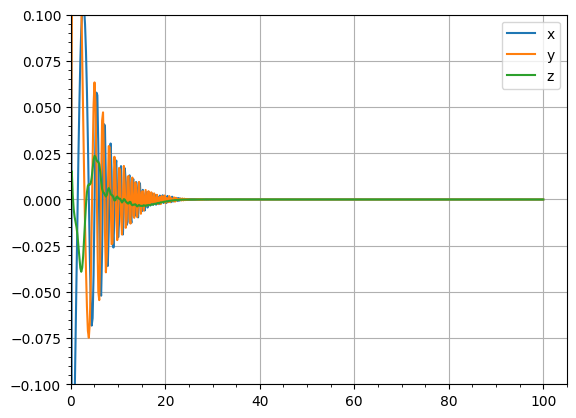

In [16]:
from copy import deepcopy
from scipy.spatial.transform import Rotation as ScipyRot
plot_err_lambda_bar = []
for idx, (t, est_rotation, rotation) in enumerate(zip(sol.t, sol_est_R, sol_R)):
    err = np.matmul(np.linalg.inv(np.array(est_rotation).reshape((3,3))), np.array(rotation).reshape((3,3)))
    err = ScipyRot.from_matrix(err)
    err = err.as_quat().tolist()
    plot_err_lambda_bar.append(err)

import matplotlib.pyplot as plt
figure = plt.subplot()

plt.plot(sol.t, np.array(plot_err_lambda_bar)[:,0:3], label=["x", "y", "z"])
plt.xlim(0)
plt.ylim(-0.1, 0.1)
plt.legend(loc="upper right")
plt.grid()
plt.minorticks_on()
plt.show()

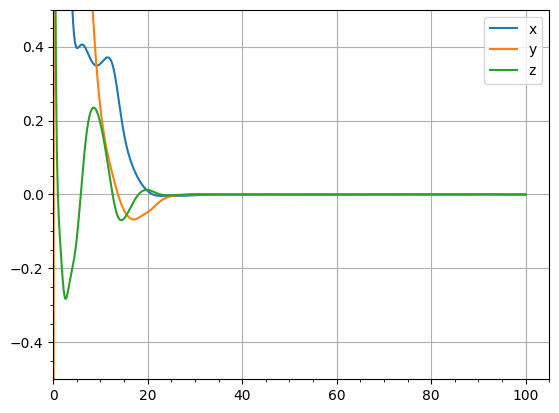

In [20]:
from copy import deepcopy
plot_est_p = []
plot_act_p_bar = []
for t, rotation, pose_hat in zip(sol.t, sol_est_R, sol_est_p):
    p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
    p_temp = np.matmul(np.linalg.inv(np.transpose(np.array(rotation).reshape((3,3)))), pose_hat)
    plot_est_p.append(p_temp)
    plot_act_p_bar.append(p)

import matplotlib.pyplot as plt
figure = plt.subplot()

# plt.plot(sol.t, plot_est_p, label=["x", "y", "z"])
# plt.xlim(0)
# plt.legend(loc="upper right")
# plt.grid()
# plt.minorticks_on()
# plt.show()

# plt.plot(sol.t, plot_act_p_bar, label=["x", "y", "z"])
# plt.xlim(0)
# plt.legend(loc="upper right")
# plt.grid()
# plt.minorticks_on()
# plt.show()

plt.plot(sol.t, np.array(plot_act_p_bar)-np.array(plot_est_p), label=["x", "y", "z"])
plt.xlim(0)
plt.ylim(-0.5, 0.5)
plt.legend(loc="upper right")
plt.grid()
plt.minorticks_on()
plt.show()


In [19]:
# from copy import deepcopy
# plot_act_p_bar = []
# for t, rotation in zip(sol.t, sol_R):
#     p = np.array([2.5+2.5*np.cos(0.4*t), 2.5*np.sin(0.4*t), 10])
#     p_bar_temp = np.matmul(np.transpose(np.array(rotation).reshape((3,3))), p).tolist()
#     plot_act_p_bar.append(p_bar_temp)

# import matplotlib.pyplot as plt
# figure = plt.subplot()
# print(sol_est_p[:, 0])
# print(plot_act_p_bar[:,0])
# plt.plot(sol.t, plot_act_p_bar, label=["x", "y", "z"])
# plt.xlim(0)
# plt.legend(loc="upper right")
# plt.grid()
# plt.minorticks_on()
# plt.show()

# plt.plot(sol.t, sol_est_p, label=["est_x", "est_y", "est_z"])
# plt.xlim(0)
# plt.legend(loc="upper right")
# plt.grid()
# plt.minorticks_on()
# plt.show()

# plt.plot(sol.t, plot_act_p_bar - sol_est_p, label=["diff_x", "diff_y", "diff_z"])
# plt.xlim(0)
# plt.ylim(-0.5, 0.5)
# plt.grid()
# plt.minorticks_on()
# plt.legend(loc="upper right")
# plt.show()